In [ ]:
!pip install alibi
!pip install captum
!pip install eli5
!pip install yellowbrick
!pip install anchor-exp


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.1/522.1 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

In [ ]:
import numpy as np
import pandas as pd
import torch

from alibi.explainers import AnchorText
from captum.attr import IntegratedGradients
from eli5.sklearn import PermutationImportance
from yellowbrick.classifier import ROCAUC
from anchor import anchor_text


RNN MODEL

In [ ]:
data = pd.read_csv('/content/twitter-suicidal_data.csv')
texts = data['tweet']  # Adjust column name as needed
labels = data['intention']      # Adjust column name as needed


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Load the dataset
df = pd.read_csv('/content/twitter-suicidal_data.csv')

# Define preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

# Apply preprocessing to the text column
df['tweet'] = df['tweet'].apply(preprocess_text)

# Split the data into train, validation, and test sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Vectorize the text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train = tfidf_vectorizer.fit_transform(train_data['tweet'])
X_val = tfidf_vectorizer.transform(val_data['tweet'])
X_test = tfidf_vectorizer.transform(test_data['tweet'])

# Encode the labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data['intention'])
y_val = label_encoder.transform(val_data['intention'])
y_test = label_encoder.transform(test_data['intention'])

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Define the RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, hidden = self.rnn(x)
        output = self.fc(hidden.squeeze(0))
        return output

# Define hyperparameters
input_size = X_train_tensor.shape[1]
hidden_size = 64
output_size = len(label_encoder.classes_)

# Instantiate the RNN model
rnn_model = RNN(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)

# Prepare DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Training loop
num_epochs = 25
for epoch in range(num_epochs):
    rnn_model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = rnn_model(inputs.unsqueeze(1))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {total_loss / len(train_loader)}")

# Evaluate the model
with torch.no_grad():
    rnn_model.eval()
    outputs = rnn_model(X_test_tensor.unsqueeze(1))
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")


Epoch 1/25, Train Loss: 0.5256314880626146
Epoch 2/25, Train Loss: 0.2699734653497851
Epoch 3/25, Train Loss: 0.19433178458102915
Epoch 4/25, Train Loss: 0.1536460793035668
Epoch 5/25, Train Loss: 0.1265780744684297
Epoch 6/25, Train Loss: 0.10687477479493895
Epoch 7/25, Train Loss: 0.09024373476588449
Epoch 8/25, Train Loss: 0.07767800871975893
Epoch 9/25, Train Loss: 0.06837136532331622
Epoch 10/25, Train Loss: 0.06076382982089769
Epoch 11/25, Train Loss: 0.05508899476465791
Epoch 12/25, Train Loss: 0.04951084225416877
Epoch 13/25, Train Loss: 0.04514366825825946
Epoch 14/25, Train Loss: 0.04074302417507698
Epoch 15/25, Train Loss: 0.03742733161333342
Epoch 16/25, Train Loss: 0.03497245800573119
Epoch 17/25, Train Loss: 0.032939006222498624
Epoch 18/25, Train Loss: 0.030553704614989286
Epoch 19/25, Train Loss: 0.02844900912930106
Epoch 20/25, Train Loss: 0.026850484046262016
Epoch 21/25, Train Loss: 0.025833011658992187
Epoch 22/25, Train Loss: 0.024526844664780032
Epoch 23/25, Train

GRADIENT ATTRIBUTION

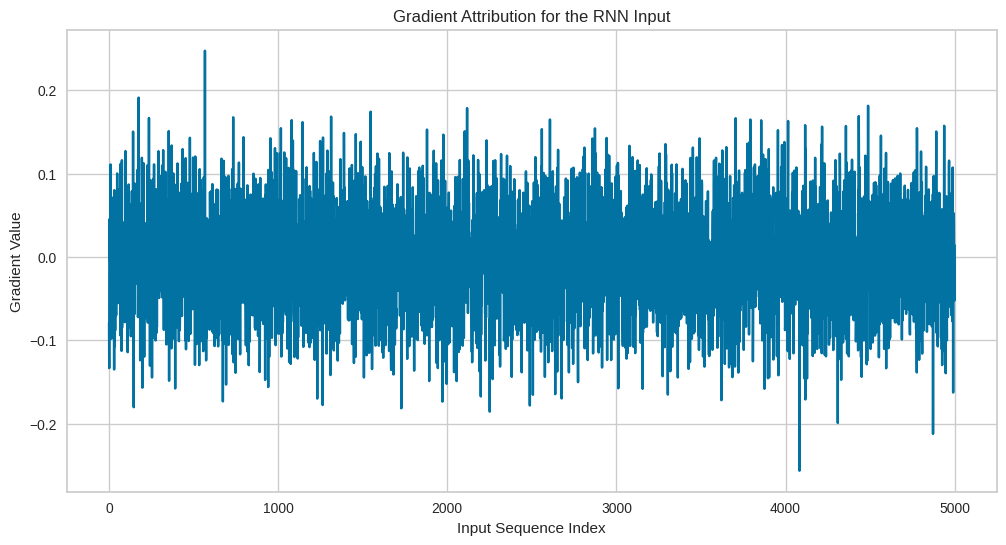

In [ ]:
def plot_gradient_attributions(model, input_tensor):
    model.eval()

    # Make input tensor requires_grad=True to compute gradients
    input_tensor.requires_grad_(True)

    # Forward pass
    output = model(input_tensor)

    # Ensure output is at least 2D
    if output.dim() == 1:
        output = output.unsqueeze(1)

    score, indices = torch.max(output, dim=1)

    # Compute gradients of the output w.r.t. input
    score.backward(torch.ones_like(score))

    # Retrieve gradients of the input
    grad = input_tensor.grad

    # Plot the gradient
    plt.figure(figsize=(12, 6))
    plt.plot(grad.numpy().ravel())
    plt.title("Gradient Attribution for the RNN Input")
    plt.xlabel("Input Sequence Index")
    plt.ylabel("Gradient Value")
    plt.grid(True)
    plt.show()

example_input = X_train_tensor[0].unsqueeze(0)
plot_gradient_attributions(rnn_model, example_input)


In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = LRPLinear(hidden_size, output_size)

    def forward(self, x):
        self.last_input = None
        _, hidden = self.rnn(x)
        hidden = hidden.squeeze(0)
        self.last_input = hidden
        output = self.fc(hidden)
        return output

    def relprop(self, R):
        return self.fc.relprop(R)


In [ ]:
class LRPLinear(nn.Module):
    """A custom linear layer for LRP that handles the relevance propagation for the output layer."""
    def __init__(self, *args, **kwargs):
        super(LRPLinear, self).__init__()
        self.linear = nn.Linear(*args, **kwargs)

    def forward(self, input):
        self.last_input = input  # Store the last input for relevance propagation
        return self.linear(input)

    def relprop(self, R):
        weight = self.linear.weight.data
        V = torch.clamp(weight, min=0)
        U = torch.clamp(weight, max=0)
        X_l = self.last_input
        Z = torch.mm(X_l, V.t()) + torch.mm(X_l, U.t()) + 1e-9  # avoid division by zero
        S = R / Z
        C = torch.mm(S, V) - torch.mm(S, U)
        return X_l * C


In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = LRPLinear(hidden_size, output_size)

    def forward(self, x):
        _, hidden = self.rnn(x)
        output = self.fc(hidden.squeeze(0))
        return output

    def relprop(self, R):
        return self.fc.relprop(R)


AnchorText Explainer - Pytorch

In [ ]:
!pip install --upgrade alibi


In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 16.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from gensim.models import Word2Vec
from alibi.explainers import AnchorText
import spacy

# Load the dataset
df = pd.read_csv('/content/twitter-suicidal_data.csv')

# Analyze dataset characteristics
print(df.info())

# Explore class distribution
print(df['intention'].value_counts())

# Adjust preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

# Apply preprocessing
df['processed_tweet'] = df['tweet'].apply(preprocess_text)

# Vectorize the text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(df['processed_tweet'])
y = df['intention']

# Encode the labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into train, validation, and test sets
X_train, X_intermediate, y_train, y_intermediate = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_intermediate, y_intermediate, test_size=0.5, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Define the RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, hidden = self.rnn(x)
        output = self.fc(hidden.squeeze(0))
        return output

# Define hyperparameters
input_size = X_train_tensor.shape[1]
hidden_size = 64
output_size = len(label_encoder.classes_)

# Instantiate the RNN model
rnn_model = RNN(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)

# Prepare DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Training loop
num_epochs = 25
for epoch in range(num_epochs):
    rnn_model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = rnn_model(inputs.unsqueeze(1))  # Add an additional dimension for sequence length
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {total_loss / len(train_loader)}")

# Evaluate the model
with torch.no_grad():
    rnn_model.eval()
    outputs = rnn_model(X_test_tensor.unsqueeze(1))  # Add an additional dimension for sequence length
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Example: Word embeddings with Word2Vec
word_embeddings = Word2Vec(sentences=df['processed_tweet'], vector_size=100, window=5, min_count=1, workers=4)

# Generate explanations with AnchorText explainer
# Load spaCy's English language small model
nlp = spacy.load('en_core_web_sm')
# Define a predictor function that takes a list of texts and returns model predictions
def model_predict(texts):
    # Preprocess the texts
    preprocessed_texts = [preprocess_text(text) for text in texts]
    # Vectorize the preprocessed texts
    vectorized_texts = tfidf_vectorizer.transform(preprocessed_texts)
    # Convert to PyTorch tensor
    X_tensor = torch.tensor(vectorized_texts.toarray(), dtype=torch.float32).unsqueeze(1)
    # Get model predictions
    with torch.no_grad():
        rnn_model.eval()
        outputs = rnn_model(X_tensor)
        probabilities = torch.softmax(outputs, dim=1).numpy()
    return probabilities

# Create an instance of the AnchorText explainer with the custom predictor function
explainer = AnchorText(predictor=model_predict, sampling_strategy='unknown', nlp=nlp)

# Choose a specific text instance from the dataset for explanation
text_instance = df['tweet'].iloc[0]  # Choose the first tweet as an example

# Generate explanations with AnchorText explainer
explanation = explainer.explain(text_instance, threshold=0.95, p_sample=0.5)

# Display explanation
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9119 entries, 0 to 9118
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      9119 non-null   object
 1   intention  9119 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 142.6+ KB
None
intention
0    5121
1    3998
Name: count, dtype: int64
Epoch 1/25, Train Loss: 0.4709506317188865
Epoch 2/25, Train Loss: 0.23208229609748773
Epoch 3/25, Train Loss: 0.17321816256694628
Epoch 4/25, Train Loss: 0.13979151472449303
Epoch 5/25, Train Loss: 0.1154595395190674
Epoch 6/25, Train Loss: 0.09874409927349341
Epoch 7/25, Train Loss: 0.08572335629478882
Epoch 8/25, Train Loss: 0.07598617081448697
Epoch 9/25, Train Loss: 0.06754299710717118
Epoch 10/25, Train Loss: 0.06078019035620648
Epoch 11/25, Train Loss: 0.05514232405020218
Epoch 12/25, Train Loss: 0.05097343032493403
Epoch 13/25, Train Loss: 0.0474392305977904
Epoch 14/25, Train Loss: 0.0440817857814724
Epoch 15

Epoch 25/25, Train Loss: 0.026575966025375874
Test Accuracy: 89.25%
Anchor: meaningless AND tragic AND hold AND completely AND end AND badly AND end
Precision: 0.95
Coverage: 0.01


In [ ]:
# Analyze dataset characteristics
print(df.info())

# Explore class distribution
print(df['intention'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9119 entries, 0 to 9118
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      9119 non-null   object
 1   intention  9119 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 142.6+ KB
None
intention
0    5121
1    3998
Name: count, dtype: int64


In [ ]:
# Explore additional text features or representations
# Example: Word embeddings with Word2Vec
from gensim.models import Word2Vec
word_embeddings = Word2Vec(sentences=df['tweet'], vector_size=100, window=5, min_count=1, workers=4)


In [ ]:
from sklearn.model_selection import cross_val_score

# Assuming 'lr_model' is your logistic regression model
scores = cross_val_score(lr_model, X_train, y_train, cv=5)  # 5-fold cross-validation
print("Accuracy scores for each fold:", scores)
print("Average cross-validation score: {:.2f}".format(scores.mean()))


Accuracy scores for each fold: [0.91638108 0.90061686 0.89376285 0.89993146 0.90061686]
Average cross-validation score: 0.90
